In [1]:
import csv
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import datetime as dt
import pandas_datareader.data as web
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests
from matplotlib import pyplot
import scipy.stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AR
%matplotlib inline

In [2]:
fpath = 'facebook_data_nytimes_post_sentiment_4dict.tsv'
post_data = pd.read_csv(fpath, sep='\t')
post_data.head()

,ID,PostID,PostDate,Text,Likes,Shares,WNPositive,WNNegative,WNNeutral,WNSentiment,...,HVTokenQnt,HVSentiAvg,LMPositive,LMNegative,LMTokenQnt,LMSentiAvg,Vader_Positive,Vader_Negative,Vader_Neutral,Vader_Compound
0,1,1.015271e+16,2021-06-13 13:55:08.667656,"Renting is, in fact, cheaper than buying these...",135,32,0.000,0.500,5.500,-0.500,...,7,0.285714,0,0,7,0.000000,0.0,0.000,1.000,0.0000
1,2,1.015271e+16,2021-06-13 13:40:09.535354,A provocative new exhibition series makes the ...,42,10,1.000,0.875,18.125,0.125,...,24,0.041667,0,2,24,-0.083333,0.0,0.024,0.976,-0.0258
2,3,1.015271e+16,2021-06-13 13:25:11.470057,The New York Times asked photography students ...,25,5,0.500,0.000,11.500,0.500,...,11,0.090909,0,0,11,0.000000,0.0,0.000,1.000,0.0000
3,4,1.015271e+16,2021-06-13 13:21:12.598040,The world's most famous sports venues are ofte...,31,4,0.625,0.250,16.125,0.375,...,12,0.416667,0,0,12,0.000000,0.0,0.000,1.000,0.0000
4,5,1.015271e+16,2021-06-13 13:21:13.300163,"“We’re back, we’re home,” one passenger yelled...",120,8,0.000,0.000,11.000,0.000,...,16,0.062500,0,0,16,0.000000,0.0,0.000,1.000,0.0000


In [3]:
post_data['Vader_Average'] = post_data['Vader_Positive'] - post_data['Vader_Negative']

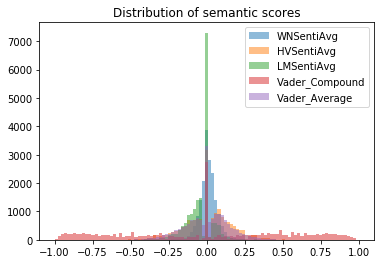

In [4]:
bins = np.linspace(-1, 1, 100)
pyplot.hist(post_data['WNSentiAvg'], bins, alpha=0.5, label='WNSentiAvg')
pyplot.hist(post_data['HVSentiAvg'], bins, alpha=0.5, label='HVSentiAvg')
pyplot.hist(post_data['LMSentiAvg'], bins, alpha=0.5, label='LMSentiAvg')
pyplot.hist(post_data['Vader_Compound'], bins, alpha=0.5, label='Vader_Compound')
pyplot.hist(post_data['Vader_Positive'] - post_data['Vader_Negative'], bins, alpha=0.5, label='Vader_Average')
pyplot.legend(loc='upper right')
pyplot.title('Distribution of semantic scores')
pyplot.show()

Text(0, 0.5, 'Posts')

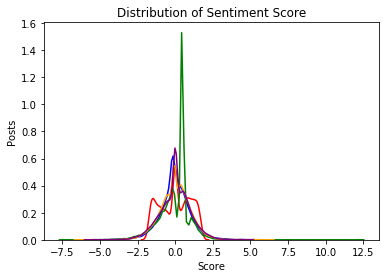

In [5]:


# seaborn histogram
sns.distplot((post_data['Vader_Compound'] - post_data['Vader_Compound'].mean())/post_data['Vader_Compound'].std(), hist=False, kde=True, 
             bins=int(180/5), color = 'red',
             hist_kws={'edgecolor':'black'})
sns.distplot((post_data['WNSentiAvg'] - post_data['WNSentiAvg'].mean())/post_data['WNSentiAvg'].std(), hist=False, kde=True, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})
sns.distplot((post_data['LMSentiAvg'] - post_data['LMSentiAvg'].mean())/post_data['LMSentiAvg'].std(), hist=False, kde=True, 
             bins=int(180/5), color = 'green',
             hist_kws={'edgecolor':'black'})
sns.distplot((post_data['HVSentiAvg'] - post_data['HVSentiAvg'].mean())/post_data['HVSentiAvg'].std(), hist=False, kde=True, 
             bins=int(180/5), color = 'orange',
             hist_kws={'edgecolor':'black'})
sns.distplot((post_data['Vader_Average'] - post_data['Vader_Average'].mean())/post_data['Vader_Average'].std(), hist=False, kde=True, 
             bins=int(180/5), color = 'purple',
             hist_kws={'edgecolor':'black'})
# Add labels
plt.title('Distribution of Sentiment Score')
plt.xlabel('Score')
plt.ylabel('Posts')

In [6]:
post_data[['WNSentiAvg','HVSentiAvg','LMSentiAvg','Vader_Compound','Vader_Average']].describe()

,WNSentiAvg,HVSentiAvg,LMSentiAvg,Vader_Compound,Vader_Average
count,17838.000000,17838.000000,17838.000000,17838.000000,17838.000000
mean,0.010070,0.011841,-0.039029,0.002970,0.000010
std,0.054760,0.160632,0.085151,0.557303,0.143522
min,-0.312500,-1.000000,-0.666667,-0.990300,-0.808000
25%,-0.017857,-0.083333,-0.083333,-0.493900,-0.085000
50%,0.007812,0.000000,0.000000,0.000000,0.000000
75%,0.041667,0.111111,0.000000,0.476700,0.088000
max,0.333333,1.000000,1.000000,0.985500,0.688000


In [7]:
post_data['PostDate'] = pd.to_datetime(post_data['PostDate'], errors='coerce')

post_data['DateMonth'] = post_data['PostDate'].dt.strftime('%Y-%m')
post_data['DateDay'] = post_data['PostDate'].dt.strftime('%Y-%m-%d')


In [8]:
post_data['DateMonth'].head()

0    2021-06
1    2021-06
2    2021-06
3    2021-06
4    2021-06
Name: DateMonth, dtype: object

In [9]:
post_data.columns

Index(['ID', 'PostID', 'PostDate', 'Text', 'Likes', 'Shares', 'WNPositive',
       'WNNegative', 'WNNeutral', 'WNSentiment', 'WNTokenQnt', 'WNSentiAvg',
       'HVPositive', 'HVNegative', 'HVTokenQnt', 'HVSentiAvg', 'LMPositive',
       'LMNegative', 'LMTokenQnt', 'LMSentiAvg', 'Vader_Positive',
       'Vader_Negative', 'Vader_Neutral', 'Vader_Compound', 'Vader_Average',
       'DateMonth', 'DateDay'],
      dtype='object')

In [10]:
Monthly_Data = post_data.groupby('DateMonth').agg({'WNSentiAvg': 'sum'
                                                         ,'WNTokenQnt':'count'
                                                        ,'Vader_Compound':'mean'
                                                        ,'Vader_Average': 'mean'
                                                        ,'HVPositive':'sum'
                                                        ,'HVNegative':'sum'
                                                        ,'HVTokenQnt':'sum'
                                                        ,'LMPositive':'sum'
                                                        ,'LMNegative':'sum'
                                                        ,'LMTokenQnt':'sum'
                                                       })

In [11]:
DailyData = post_data.groupby('DateDay').agg({'WNSentiAvg': 'sum'
                                                        ,'WNTokenQnt':'count'
                                                        ,'Vader_Compound':'mean'
                                                        ,'Vader_Average': 'mean'
                                                        ,'HVPositive':'sum'
                                                        ,'HVNegative':'sum'
                                                        ,'HVTokenQnt':'sum'
                                                        ,'LMPositive':'sum'
                                                        ,'LMNegative':'sum'
                                                        ,'LMTokenQnt':'sum'
                                                        })

In [12]:
DailyData['WNSentiment'] =  DailyData['WNSentiAvg']/ DailyData['WNTokenQnt']
DailyData['HVSentiment'] = (DailyData['HVPositive'] - DailyData['HVNegative'])/DailyData['HVTokenQnt']
DailyData['LMSentiment'] = (DailyData['LMPositive'] - DailyData['LMNegative'])/DailyData['LMTokenQnt']

Monthly_Data['WNSentiment'] =  Monthly_Data['WNSentiAvg']/ Monthly_Data['WNTokenQnt']
Monthly_Data['HVSentiment'] = (Monthly_Data['HVPositive'] - Monthly_Data['HVNegative'])/Monthly_Data['HVTokenQnt']
Monthly_Data['LMSentiment'] = (Monthly_Data['LMPositive'] - Monthly_Data['LMNegative'])/Monthly_Data['LMTokenQnt']



In [13]:
print('Results of Dickey-Fuller Test:')
dftest = adfuller(DailyData['WNSentiment'].dropna(), autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
for i in range(len(dfoutput)):
    dfoutput[i] = round(dfoutput[i],4)
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                  -22.6487
p-value                           0.0000
#Lags Used                        2.0000
Number of Observations Used    1902.0000
Critical Value (1%)              -3.4338
Critical Value (5%)              -2.8631
Critical Value (10%)             -2.5676
dtype: float64


In [14]:
print('Results of Dickey-Fuller Test:')
dftest = adfuller(DailyData['HVSentiment'].dropna(), autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
for i in range(len(dfoutput)):
    dfoutput[i] = round(dfoutput[i],4)
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                   -8.7223
p-value                           0.0000
#Lags Used                       12.0000
Number of Observations Used    1892.0000
Critical Value (1%)              -3.4338
Critical Value (5%)              -2.8631
Critical Value (10%)             -2.5676
dtype: float64


In [15]:
for i in range(len(dfoutput)):
    dfoutput[i] = round(dfoutput[i],4)
print(dfoutput)
print('Results of Dickey-Fuller Test:')
dftest = adfuller(DailyData['LMSentiment'].dropna(), autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value


Test Statistic                   -8.7223
p-value                           0.0000
#Lags Used                       12.0000
Number of Observations Used    1892.0000
Critical Value (1%)              -3.4338
Critical Value (5%)              -2.8631
Critical Value (10%)             -2.5676
dtype: float64
Results of Dickey-Fuller Test:


In [16]:
for i in range(len(dfoutput)):
    dfoutput[i] = round(dfoutput[i],4)
print(dfoutput)
print('Results of Dickey-Fuller Test:')
dftest = adfuller(DailyData['Vader_Compound'].dropna(), autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value


Test Statistic                   -6.7712
p-value                           0.0000
#Lags Used                       13.0000
Number of Observations Used    1891.0000
Critical Value (1%)              -3.4338
Critical Value (5%)              -2.8631
Critical Value (10%)             -2.5676
dtype: float64
Results of Dickey-Fuller Test:


In [17]:
DailyData.head()

,WNSentiAvg,WNTokenQnt,Vader_Compound,Vader_Average,HVPositive,HVNegative,HVTokenQnt,LMPositive,LMNegative,LMTokenQnt,WNSentiment,HVSentiment,LMSentiment
DateDay,,,,,,,,,,,,,
2011-08-03,0.246334,5,0.511300,0.147400,16,7,74,3,2,74,0.049267,0.121622,0.013514
2011-08-04,0.009375,5,0.236620,0.049000,7,5,52,2,0,52,0.001875,0.038462,0.038462
2011-08-05,0.085519,9,0.058711,-0.039778,21,11,133,4,6,133,0.009502,0.075188,-0.015038
2011-08-06,-0.052083,5,-0.224080,-0.029000,14,15,81,4,8,81,-0.010417,-0.012346,-0.049383
2011-08-07,0.348734,6,0.126850,0.080667,18,5,67,0,5,67,0.058122,0.194030,-0.074627


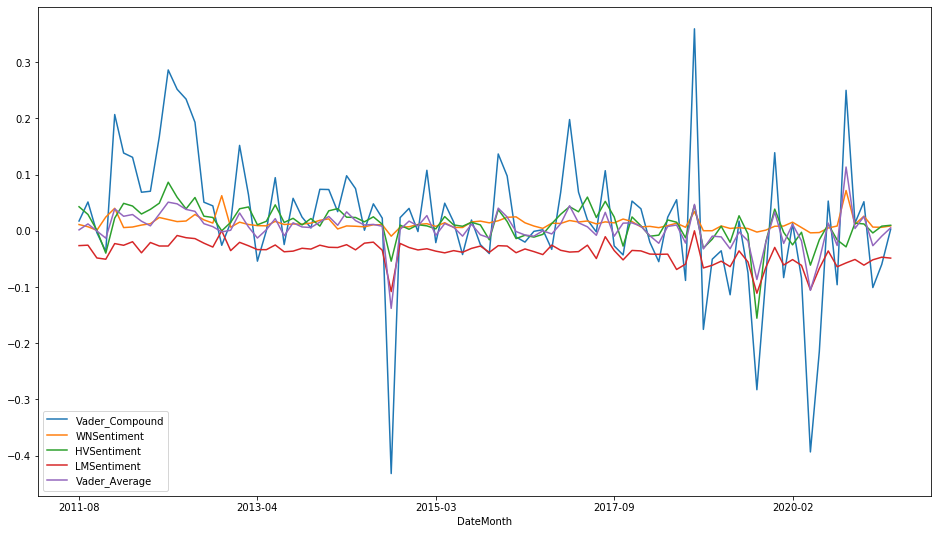

In [18]:
Monthly_Data[['Vader_Compound','WNSentiment','HVSentiment','LMSentiment','Vader_Average']].plot(legend=True, figsize=(16,9))

## Download S&P from Yahoo

In [19]:
SnP_daily = web.get_data_yahoo('^GSPC','10/01/2010','05/01/2021',interval='d')
SnP_monthly = web.get_data_yahoo('^GSPC','10/01/2010','05/01/2021',interval='m')

In [20]:
SnP_daily['LogReturn'] = np.log(SnP_daily['Adj Close']/SnP_daily['Adj Close'].shift(1))

In [21]:
SnP_monthly.index = SnP_monthly.index.strftime('%Y-%m')

In [22]:
SnP_monthly['LogReturn'] = np.log(SnP_monthly['Adj Close']/SnP_monthly['Adj Close'].shift(1))

## Granger test

In [23]:
Granger_data_daily = pd.merge(SnP_daily,DailyData, how= 'inner', left_index=True, right_index=True)

In [24]:
def grangerTest(exog, endog):
    MAX_LAG = 30
    ARaic = AR(exog.tolist()).fit(maxlag=MAX_LAG, ic="aic")
    ARbic = AR(exog.tolist()).fit(maxlag=MAX_LAG, ic="bic")
    # select the fewer number of parameters between both criteria.
    numExog = len(ARaic.params) if len(ARaic.params) < len(ARbic.params) else len(ARbic.params)

    print ("Optimal number of lags for exog data is " + str(numExog))

    ARaic = AR(endog.tolist()).fit(maxlag=MAX_LAG, ic="aic")
    ARbic = AR(endog.tolist()).fit(maxlag=MAX_LAG, ic="bic")
    # select the fewer number of parameters between both criteria.
    numEndog = len(ARaic.params) if len(ARaic.params) < len(ARbic.params) else len(ARbic.params)

    print ("Optimal number of lags for endog data is " + str(numEndog))

    # now that I know the optimal number of parameters, I can call the
    # granger causality function of statsmodels.
    data = pd.concat([endog, exog], axis=1)
    print ("\nGranger causality results of indep onto dep")
    results = grangercausalitytests(data, maxlag=numEndog)

    data = pd.concat([exog, endog], axis=1)
    print ("\nGranger causality results of dep onto indep")
    results = grangercausalitytests(data, maxlag=numExog)
    regr = results[2][1]
    print (regr[0].params)
    print (regr[1].params)
    print (regr[1].pvalues)

In [25]:
Granger_data_monthly = pd.merge(SnP_monthly,Monthly_Data, how= 'inner', left_index=True, right_index=True)

In [26]:
#Granger_data['SS_LogReturn'] = np.log((Granger_data['SentimentScoreAdj']+1)/(Granger_data['SentimentScoreAdj']+1).shift(1))

In [27]:
Granger_data_monthly

,High,Low,Open,Close,Volume,Adj Close,LogReturn,WNSentiAvg,WNTokenQnt,Vader_Compound,Vader_Average,HVPositive,HVNegative,HVTokenQnt,LMPositive,LMNegative,LMTokenQnt,WNSentiment,HVSentiment,LMSentiment
2011-08,1307.380005,1101.540039,1292.589966,1218.890015,108419170000,1218.890015,-0.058468,1.972486,177,0.017398,0.001655,344,240,2428,40,104,2428,0.011144,0.042834,-0.026359
2011-09,1229.290039,1114.219971,1219.119995,1131.420044,102786820000,1131.420044,-0.074467,1.444403,200,0.051330,0.012260,471,373,3363,66,152,3363,0.007222,0.029141,-0.025572
2011-10,1292.660034,1074.770020,1131.209961,1253.300049,98063670000,1253.300049,0.102307,0.117718,126,-0.003265,-0.000333,270,268,1966,25,120,1966,0.000934,0.001017,-0.048321
2011-11,1277.550049,1158.660034,1251.000000,1246.959961,84275050000,1246.959961,-0.005072,0.244905,10,-0.036710,-0.013100,15,26,277,1,15,277,0.024490,-0.039711,-0.050542
2011-12,1269.369995,1202.369995,1246.910034,1257.599976,74742430000,1257.599976,0.008497,0.400711,10,0.206940,0.039100,23,17,264,0,6,264,0.040071,0.022727,-0.022727
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11,3645.989990,3279.739990,3296.199951,3621.629883,100977880000,3621.629883,0.102146,0.286879,4,0.250000,0.113500,10,12,70,0,4,70,0.071720,-0.028571,-0.057143
2020-12,3760.199951,3633.399902,3645.870117,3756.070068,96056410000,3756.070068,0.036449,5.104407,437,0.013729,0.004137,1211,1092,8726,130,575,8726,0.011681,0.013637,-0.050997
2021-02,3950.429932,3725.620117,3731.169922,3811.149902,98596960000,3811.149902,0.025757,1.273666,49,0.051782,0.025551,119,108,900,17,72,900,0.025993,0.012222,-0.061111
2021-03,3994.409912,3723.340088,3842.510010,3972.889893,120863560000,3972.889893,0.041563,5.589748,844,-0.100986,-0.026464,2217,2281,16920,268,1141,16920,0.006623,-0.003783,-0.051596


In [29]:
Vars = ["Vader_Compound","Vader_Average","WNSentiment","HVSentiment","LMSentiment"]
for Var in Vars:
    print("\n" + Var + "\n")
    grangerTest(Granger_data_daily[Var], Granger_data_daily['LogReturn'])


Vader_Compound

Optimal number of lags for exog data is 7
Optimal number of lags for endog data is 9

Granger causality results of indep onto dep

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.0643  , p=0.0803  , df_denom=1324, df_num=1
ssr based chi2 test:   chi2=3.0712  , p=0.0797  , df=1
likelihood ratio test: chi2=3.0677  , p=0.0799  , df=1
parameter F test:         F=3.0643  , p=0.0803  , df_denom=1324, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.3998  , p=0.0337  , df_denom=1321, df_num=2
ssr based chi2 test:   chi2=6.8252  , p=0.0330  , df=2
likelihood ratio test: chi2=6.8077  , p=0.0332  , df=2
parameter F test:         F=3.3998  , p=0.0337  , df_denom=1321, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.4797  , p=0.0596  , df_denom=1318, df_num=3
ssr based chi2 test:   chi2=7.4785  , p=0.0581  , df=3
likelihood ratio test: chi2=7.4575  , p=0.0587  , df=3
parameter F tes

number of lags (no zero) 2
ssr based F test:         F=1.3796  , p=0.2520  , df_denom=1321, df_num=2
ssr based chi2 test:   chi2=2.7696  , p=0.2504  , df=2
likelihood ratio test: chi2=2.7667  , p=0.2507  , df=2
parameter F test:         F=1.3796  , p=0.2520  , df_denom=1321, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.9929  , p=0.3953  , df_denom=1318, df_num=3
ssr based chi2 test:   chi2=2.9944  , p=0.3925  , df=3
likelihood ratio test: chi2=2.9911  , p=0.3930  , df=3
parameter F test:         F=0.9929  , p=0.3953  , df_denom=1318, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.8031  , p=0.1258  , df_denom=1315, df_num=4
ssr based chi2 test:   chi2=7.2617  , p=0.1227  , df=4
likelihood ratio test: chi2=7.2418  , p=0.1236  , df=4
parameter F test:         F=1.8031  , p=0.1258  , df_denom=1315, df_num=4

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.4549  , p=0.2018  , df_denom=13

Optimal number of lags for exog data is 11
Optimal number of lags for endog data is 9

Granger causality results of indep onto dep

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5836  , p=0.4450  , df_denom=1324, df_num=1
ssr based chi2 test:   chi2=0.5849  , p=0.4444  , df=1
likelihood ratio test: chi2=0.5848  , p=0.4444  , df=1
parameter F test:         F=0.5836  , p=0.4450  , df_denom=1324, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5110  , p=0.6000  , df_denom=1321, df_num=2
ssr based chi2 test:   chi2=1.0258  , p=0.5988  , df=2
likelihood ratio test: chi2=1.0254  , p=0.5989  , df=2
parameter F test:         F=0.5110  , p=0.6000  , df_denom=1321, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.4022  , p=0.7514  , df_denom=1318, df_num=3
ssr based chi2 test:   chi2=1.2132  , p=0.7499  , df=3
likelihood ratio test: chi2=1.2126  , p=0.7500  , df=3
parameter F test:         F=0.4

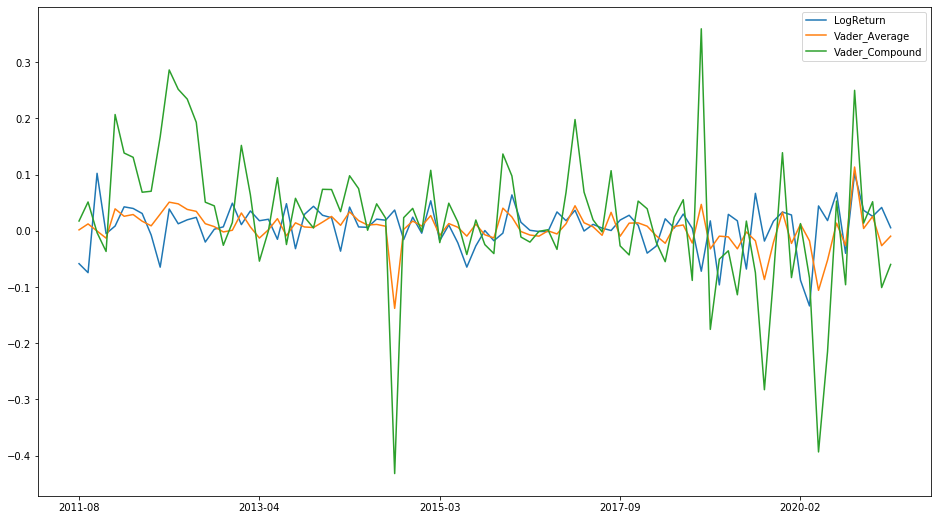

In [30]:
Granger_data_monthly[['LogReturn','Vader_Average','Vader_Compound']].plot(legend=True, figsize=(16,9))

In [31]:
corr = Granger_data_daily[["Vader_Compound","Vader_Average","WNSentiment","HVSentiment","LMSentiment","LogReturn"]].corr()
corr.style.background_gradient(cmap='coolwarm')

,Vader_Compound,Vader_Average,WNSentiment,HVSentiment,LMSentiment,LogReturn
Vader_Compound,1.000000,0.911065,0.372253,0.577090,0.539055,0.031721
Vader_Average,0.911065,1.000000,0.400447,0.577280,0.556277,0.043042
WNSentiment,0.372253,0.400447,1.000000,0.313307,0.247067,0.022266
HVSentiment,0.577090,0.577280,0.313307,1.000000,0.511389,0.019764
LMSentiment,0.539055,0.556277,0.247067,0.511389,1.000000,0.059273
LogReturn,0.031721,0.043042,0.022266,0.019764,0.059273,1.000000


In [32]:
pvals = [] 
for col in ["Vader_Compound","Vader_Average","WNSentiment","HVSentiment","LMSentiment"]:
    pvals.append(scipy.stats.linregress(Granger_data_daily['LogReturn'][1:], Granger_data_daily[col][1:].dropna())[3])
corr_signif = pd.DataFrame(pvals,columns = ['p-value']
                           ,index = ["Vader_Compound","Vader_Average","WNSentiment","HVSentiment","LMSentiment"])
#print(corr_signif.to_latex())
print(corr_signif)

                 p-value
Vader_Compound  0.256623
Vader_Average   0.122612
WNSentiment     0.428031
HVSentiment     0.483399
LMSentiment     0.031980


In [38]:
pvals_mnt = [] 
for col in ['Vader_Compound','Flair_Score','SentimentScoreAdj','Vader_Average']:
    pvals_mnt.append(scipy.stats.linregress(Granger_data_monthly['LogReturn'][1:], Granger_data_monthly[col][1:].dropna())[3])
corr_signif_mnt = pd.DataFrame(pvals_mnt,columns = ['p-value']
                           ,index = ['Vader_Compound','Flair_Score','SentimentScoreAdj','Vader_Average'])
corr_signif_mnt

,p-value
Vader_Compound,0.084306
Flair_Score,0.977764
SentimentScoreAdj,0.311650
Vader_Average,0.047369


In [33]:
DailyData.to_csv('NyTimes_variables.tsv', sep='\t')